In [10]:
import os
import sys
import math
import random
import statistics
import numpy as np
import pandas as pd
from sklearn.metrics import auc
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
import seaborn as sb
sb.set_style("whitegrid")

cb_palette = ['#377eb8', '#ff7f00', '#4daf4a',
              '#f781bf', '#a65628', '#984ea3',
              '#999999', '#e41a1c', '#dede00']
sb.color_palette(cb_palette)


bsfolder = '/home/gabriele/Desktop/BindingSite_docking_master/'
codelist = [line.rstrip() for line in open(bsfolder+'list_dimers')]
chainlist = []
for code in codelist:
    chainlist.append(code+'_u1')
    chainlist.append(code+'_u2')

def load_resfile(file):
    res = {}
    for line in open(bsfolder+'results/'+file):
        code = line.split()[-1].split('/')[-1].split('_')[0]
        dockq = float(line.split()[1])
        if not code in res: res[code] = []
        res[code].append(dockq)
    return res

#dockqs = {'Greal':load_resfile('Greal'),
#          'G02505':load_resfile('G02505'), 'G025075':load_resfile('G025075'),
#          'G0505':load_resfile('G0505'), 'G05075':load_resfile('G05075'),
#          'GISP':load_resfile('GISP'), 'GSPP':load_resfile('GSPP'),
#          'Gr4s':load_resfile('Gr4s'), 'Gdyn':load_resfile('Gdyn'),
          
#          'Preal':load_resfile('Preal'),
#          'P02505':load_resfile('P02505'), 'P025075':load_resfile('P025075'),
#          'P0505':load_resfile('P0505'), 'P05075':load_resfile('P05075'),
#          'PISP':load_resfile('PISP'), 'PSPP':load_resfile('PSPP'),
#          'Pr4s':load_resfile('Pr4s'), 'Pdyn':load_resfile('Pdyn')}


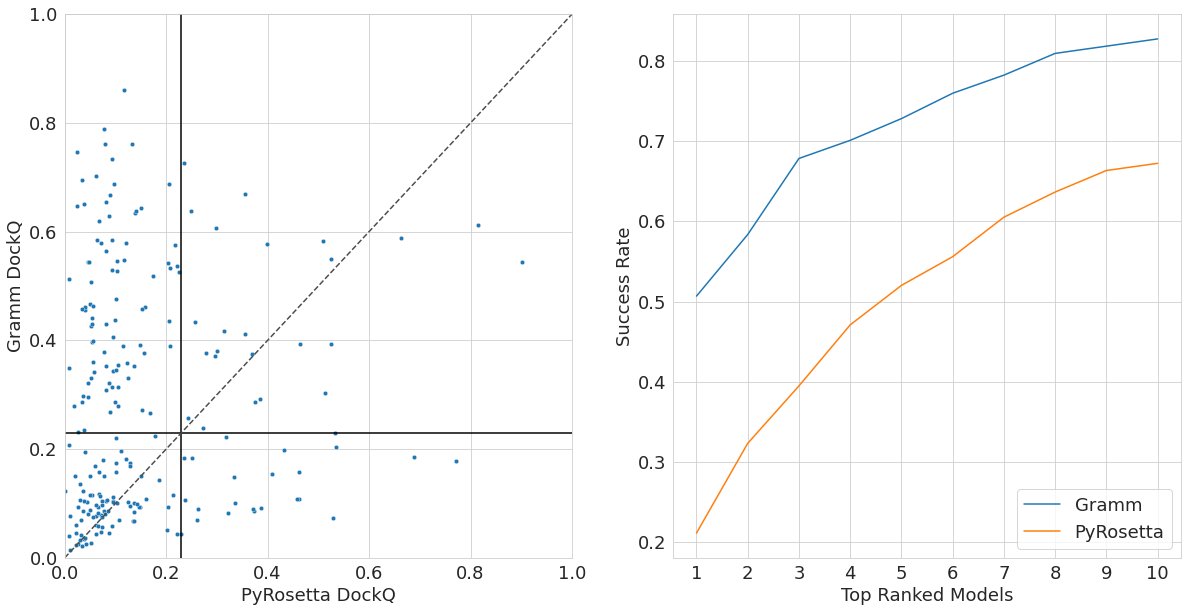

In [3]:
def compare_two(key1, key2, lbl1, lbl2):
    res1 = {key:dockqs[key1][key][0] for key in dockqs[key1]}
    res2 = {key:dockqs[key2][key][0] for key in dockqs[key2]}
    
    
    set1 = set(res1.keys())
    set2 = set(res2.keys())
    common = list(set1.intersection(set2))
    
    dic = {lbl1:[], lbl2:[]}
    for code in common:
        dic[lbl1].append(res1[code])
        dic[lbl2].append(res2[code])
        
    dic = pd.DataFrame(dic)
    return dic

def success_rate(runs):
    succ_rates = {'TopMod.':list(range(1,11))}
    for runkey in runs:
        for top in range(1,11):
            res = {key:max(dockqs[runkey][key][:top]) for key in dockqs[runkey]}
            success = [1 if res[key] >= 0.23 else 0 for key in res]
            if not runkey in succ_rates: succ_rates[runkey] = []
            succ_rates[runkey].append(sum(success)/len(success))

    succ_rates = pd.DataFrame(succ_rates)
    return succ_rates

lbl1 = 'PyRosetta DockQ'
lbl2 = 'Gramm DockQ'
dic = compare_two('Preal', 'Greal', lbl1, lbl2)
succ_rates = success_rate(['Greal', 'Preal'])

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
sb.scatterplot(x=lbl1, y=lbl2, data=dic, s=20, ax=axes[0])
axes[0].vlines(0.23, 0, 1, 'black')
axes[0].hlines(0.23, 0, 1, 'black')
axes[0].plot([0, 1], [0, 1], ls="--", c=".3")
axes[0].set_xlim(0,1)
axes[0].set_ylim(0,1)

sb.lineplot(x='TopMod.', y='Greal', data=succ_rates, label='Gramm', ax=axes[1])
sb.lineplot(x='TopMod.', y='Preal', data=succ_rates, label='PyRosetta', ax=axes[1])
axes[1].set_ylabel("Success Rate")
axes[1].set_xlabel("Top Ranked Models")
axes[1].set_xticks(np.arange(1,11))
plt.legend(loc='lower right')

fig.savefig(bsfolder+'pictures/pyrosettavsgramm_realBS.png')
plt.show()
    

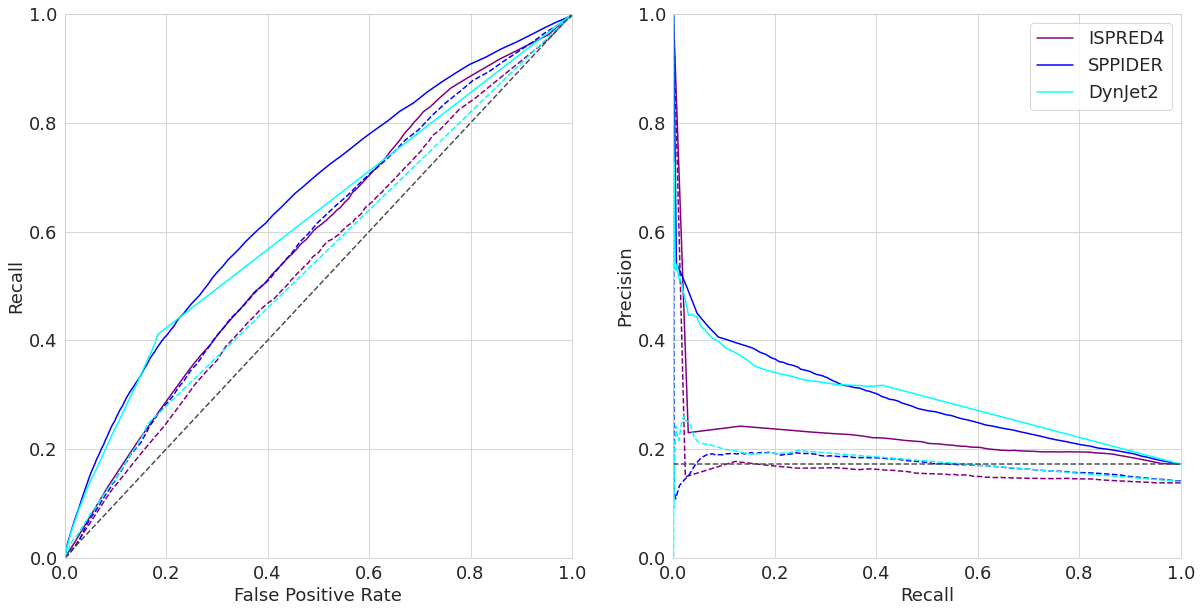

In [32]:
def get_topF1(scores, top):
    TP = FP = FN = TN = 0
    for p, real in enumerate(scores):
        if p < top:
            if real == 1.0: TP += 1
            if real == 0.0: FP += 1
        if p >= top:
            if real == 1.0: FN += 1
            if real == 0.0: TN += 1
    if TP != 0: 
        TPR = TP/(TP+FN)
        PPV = TP/(TP+FP)
        return 2*(PPV*TPR)/(PPV+TPR)
    else: 
        return 0.0
    
def get_thrF1(scores, thr):
    TP = FP = FN = TN = 0
    for pred, real in scores:
        if pred >= thr:
            if real == 1.0: TP += 1
            if real == 0.0: FP += 1
        if pred < thr:
            if real == 1.0: FN += 1
            if real == 0.0: TN += 1
    if TP != 0:
        TPR = TP/(TP+FN)
        PPV = TP/(TP+FP)
        return 2*(PPV*TPR)/(PPV+TPR)
    else: 
        return 0.0

def compute_auc_stats(scores):
    predscores = np.array(scores)
    predscores = predscores[:,0]
    realscores = np.array(scores)
    realscores = realscores[:,1].flatten()
    rFPR, rTPR, rTHR = roc_curve(realscores, predscores)
    pPPV, pTPR, pTHR = precision_recall_curve(realscores, predscores)
    stats = {'rFPR':rFPR, 'rTPR':rTPR, 'pTPR':pTPR, 'pPPV':pPPV}
    return stats
    
def BSpred_stats(n,  label):
    allscores = []
    dimerscores = []
    worstscores = []
    chainscores1 = []
    chainscores2 = []
    topout = open(bsfolder+'data/topF1_'+label, 'w')
    throut = open(bsfolder+'data/thrF1_'+label, 'w')
    for code in chainlist:
        pdbcode = code[:4]
        labelfile = bsfolder+'data/formatted_labels/'+code+'.pred'
        if not os.path.exists(labelfile): 
            print (labelfile, 'not found!')
            continue
        isp = [float(line.split()[n]) for line in open(labelfile)]
        ist = [float(line.split()[1]) for line in open(labelfile)]
        rsa = [float(line.split()[0]) for line in open(labelfile)]
        for lp, lt, acc in zip(isp, ist, rsa):
            if acc < 0.2: continue
            allscores.append([lp, lt])
            dimerscores.append([lp, lt])
            if '_u1' in code: chainscores1.append([lp, lt])
            else: chainscores2.append([lp, lt])
            
        if '_u2' in code:
            dimerscores = np.array(dimerscores)
            dimerscores = dimerscores[dimerscores[:,0].argsort()[::-1]]
            topF1 = get_topF1(dimerscores[:,1], 15)
            thrF1 = get_thrF1(dimerscores, 0.5)
            topout.write(pdbcode+'  '+str(round(topF1, 2))+'\n')
            throut.write(pdbcode+'  '+str(round(thrF1, 2))+'\n')
            dimerscores = []
            
            stats1 = compute_auc_stats(chainscores1)
            stats2 = compute_auc_stats(chainscores2)
            auc1 = auc(stats1['pTPR'], stats1['pPPV'])
            auc2 = auc(stats2['pTPR'], stats2['pPPV'])            
            if auc1 < auc2: worstscores += chainscores1
            else: worstscores += chainscores2
            chainscores1 = []
            chainscores2 = []
            
    allstats = compute_auc_stats(allscores)
    worststats = compute_auc_stats(worstscores)
    return allstats, worststats

isp, isp_w = BSpred_stats(6, 'ISP')
spp, spp_w = BSpred_stats(7, 'SPP')
#r4s = BSpred_stats(8, 'r4s')
dyn, dyn_w = BSpred_stats(8, 'dyn')
auROC_isp = round(auc(isp['rFPR'], isp['rTPR']),2)
auROC_spp = round(auc(spp['rFPR'], spp['rTPR']),2)
#auROC_r4s = round(auc(r4s['rFPR'], r4s['rTPR']),2)
auROC_dyn = round(auc(dyn['rFPR'], dyn['rTPR']),2)
auPR_isp = round(auc(isp['pTPR'], isp['pPPV']),2)
auPR_spp = round(auc(spp['pTPR'], spp['pPPV']),2)
#auPR_r4s = round(auc(r4s['pTPR'], r4s['pPPV']),2)
auPR_dyn = round(auc(dyn['pTPR'], dyn['pPPV']),2)

cb_palette = 'red'

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
sb.lineplot(x='rFPR', y='rTPR', data=isp, color='purple', ax=axes[0])
axes[0].plot(isp_w['rFPR'], isp_w['rTPR'], ls="--", color='purple')
sb.lineplot(x='rFPR', y='rTPR', data=spp, color='blue', ax=axes[0])
axes[0].plot(spp_w['rFPR'], spp_w['rTPR'], ls="--", color='blue')
#sb.lineplot(x='rFPR', y='rTPR', data=r4s, color='orange', ax=axes[0])
sb.lineplot(x='rFPR', y='rTPR', data=dyn, color='cyan', ax=axes[0])
axes[0].plot(dyn_w['rFPR'], dyn_w['rTPR'], ls="--", color='cyan')
axes[0].plot([0, 1], [0, 1], ls="--", c=".3")

sb.lineplot(x='pTPR', y='pPPV', data=isp, label='ISPRED4', color='purple', ax=axes[1])
axes[1].plot(isp_w['pTPR'], isp_w['pPPV'], ls="--", color='purple')
sb.lineplot(x='pTPR', y='pPPV', data=spp, label='SPPIDER', color='blue', ax=axes[1])
axes[1].plot(spp_w['pTPR'], spp_w['pPPV'], ls="--", color='blue')
#sb.lineplot(x='pTPR', y='pPPV', data=r4s, label='Rate4Site', color='orange', ax=axes[1])
sb.lineplot(x='pTPR', y='pPPV', data=dyn, label='DynJet2', color='cyan', ax=axes[1])
axes[1].plot(dyn_w['pTPR'], dyn_w['pPPV'], ls="--", color='cyan')

axes[1].plot([0, 1], [isp['pPPV'][0], isp['pPPV'][0]], ls="--", c=".3")
axes[0].set_xlim(0,1)
axes[0].set_ylim(0,1)
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("Recall")
axes[1].set_xlim(0,1)
axes[1].set_ylim(0,1)
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
fig.savefig(bsfolder+'pictures/ROC-PR_stats.png', 
            facecolor='white', transparent=False)
plt.show()
#make lines thick


(0.0, 1.0)

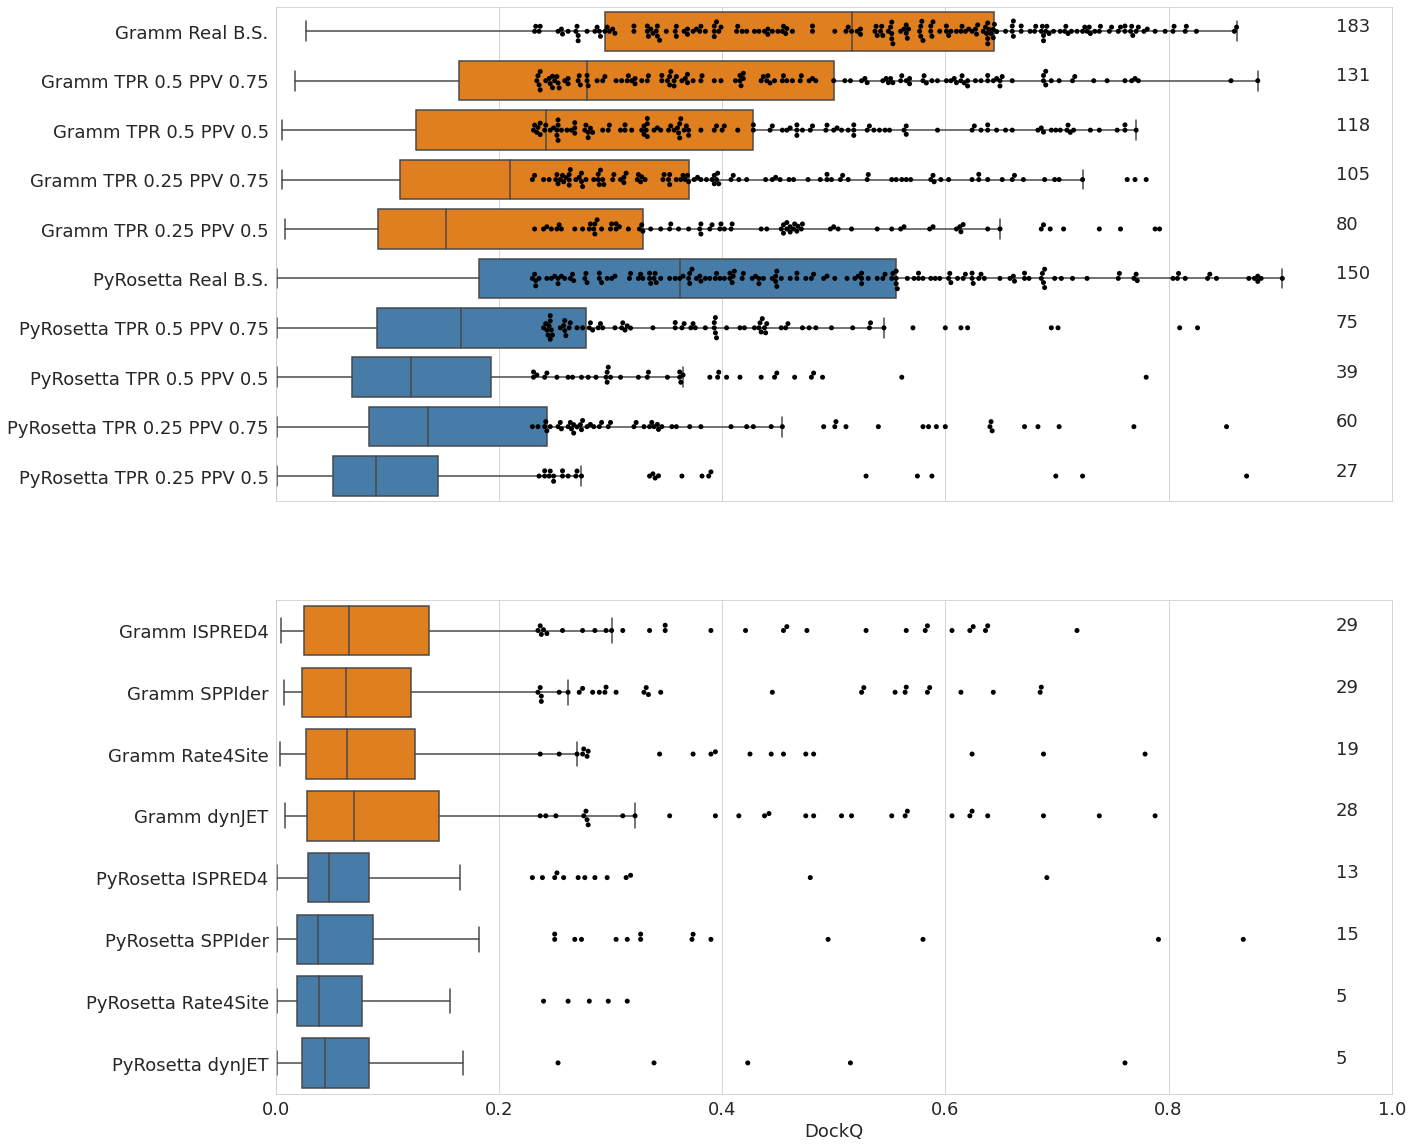

In [20]:
name_refine = { 
    'Greal':'Gramm Real B.S.',
    'G025075':'Gramm TPR 0.25 PPV 0.75',
    'G02505':'Gramm TPR 0.25 PPV 0.5',
    'G05075':'Gramm TPR 0.5 PPV 0.75',
    'G0505':'Gramm TPR 0.5 PPV 0.5',
    'GISP':'Gramm ISPRED4',
    'GSPP':'Gramm SPPIder',
    'Gr4s':'Gramm Rate4Site',
    'Gdyn':'Gramm dynJET',
    'Preal':'PyRosetta Real B.S.',
    'P025075':'PyRosetta TPR 0.25 PPV 0.75',
    'P02505':'PyRosetta TPR 0.25 PPV 0.5',
    'P05075':'PyRosetta TPR 0.5 PPV 0.75',
    'P0505':'PyRosetta TPR 0.5 PPV 0.5',
    'PISP':'PyRosetta ISPRED4',
    'PSPP':'PyRosetta SPPIder',
    'Pr4s':'PyRosetta Rate4Site',
    'Pdyn':'PyRosetta dynJET'}

def compare_runs_top1(runs, top1=True):
    countdic = {}
    bardic = {'DockQ':[], 'Setup':[]}
    swarmdic = {'DockQ':[], 'Setup':[]}
    for run in runs:
        if top1:
            countdic[run] = len([1 for code in dockqs[run] if dockqs[run][code][0] >= 0.23])
            for code in dockqs[run]:
                bardic['DockQ'].append(dockqs[run][code][0])
                bardic['Setup'].append(name_refine[run])
                if dockqs[run][code][0] >= 0.23: 
                    swarmdic['DockQ'].append(dockqs[run][code][0])
                    swarmdic['Setup'].append(name_refine[run])
            if not name_refine[run] in swarmdic['Setup']:
                swarmdic['DockQ'].append(-1)
                swarmdic['Setup'].append(name_refine[run])
        else:
            countdic[run] = len([1 for code in dockqs[run] if max(dockqs[run][code]) >= 0.23])
            for code in dockqs[run]:
                bardic['DockQ'].append(max(dockqs[run][code]))
                bardic['Setup'].append(name_refine[run])
                if max(dockqs[run][code]) >= 0.23: 
                    swarmdic['DockQ'].append(max(dockqs[run][code]))
                    swarmdic['Setup'].append(name_refine[run])
            if not name_refine[run] in swarmdic['Setup']:
                swarmdic['DockQ'].append(-1)
                swarmdic['Setup'].append(name_refine[run])
    return bardic, swarmdic, countdic

fig, axes = plt.subplots(2, 1, figsize=(20, 20), sharex=True)

randomized_runs = ['Greal', 'G05075', 'G0505', 'G025075', 'G02505',
                   'Preal', 'P05075', 'P0505', 'P025075', 'P02505']
bardic, swarmdic, countdic = compare_runs_top1(randomized_runs, top1=False)
palette = {setup:'#377eb8' if 'PyRosetta' in setup else '#ff7f00'\
           for setup in set(bardic['Setup'])}

sb.swarmplot(x='DockQ', y='Setup', data=swarmdic, color='Black', size=5, ax=axes[0])
sb.boxplot(x='DockQ', y='Setup', data=bardic, showfliers=False, palette=palette, ax=axes[0])
for n, lbl in enumerate(countdic): axes[0].text(x=0.95, y=n, s=countdic[lbl])
axes[0].set_xticks(np.arange(0, 1.1, 0.2))

randomized_runs = ['GISP', 'GSPP', 'Gr4s', 'Gdyn',
                   'PISP', 'PSPP', 'Pr4s', 'Pdyn']
bardic, swarmdic, countdic = compare_runs_top1(randomized_runs, top1=False)
palette = {setup:'#377eb8' if 'PyRosetta' in setup else '#ff7f00'\
           for setup in set(bardic['Setup'])}

sb.swarmplot(x='DockQ', y='Setup', data=swarmdic, color='Black', size=5, ax=axes[1])
sb.boxplot(x='DockQ', y='Setup', data=bardic, showfliers=False, palette=palette, ax=axes[1])
for n, lbl in enumerate(countdic): axes[1].text(x=0.95, y=n, s=countdic[lbl])
axes[1].set_xticks(np.arange(0, 1.1, 0.2))
axes[1].set_xlabel('DockQ')
axes[1].set_xlim(0,1)


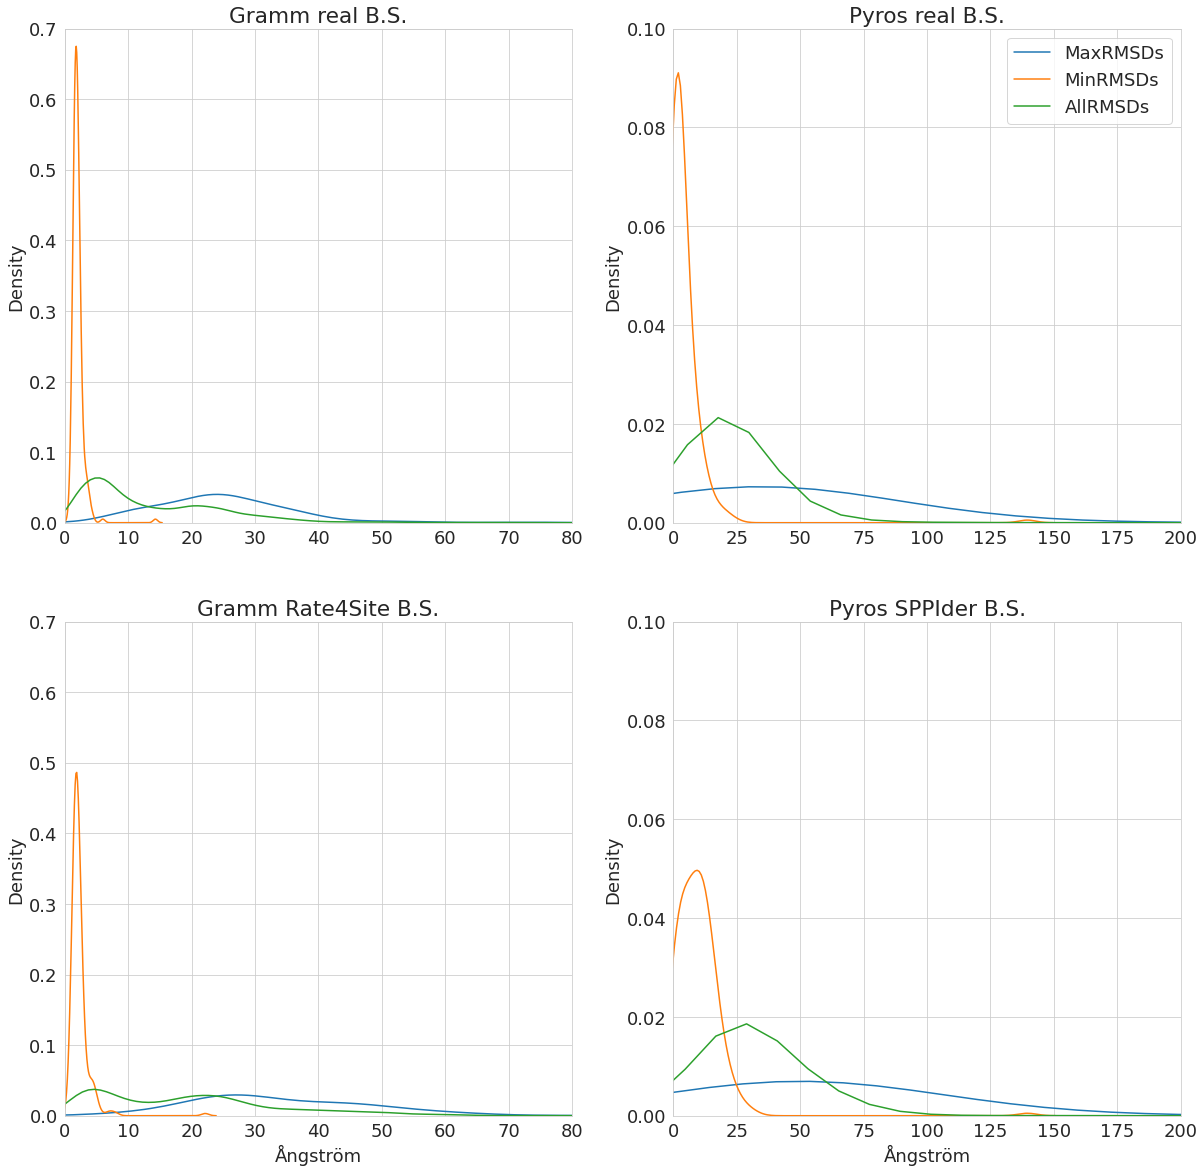

In [7]:
def rmsd_scattering():
    rundic = {}
    runs = ['Greal', 'Preal', 'Gr4s', 'PSPP']
    fig, axes = plt.subplots(2, 2, figsize=(20, 20))
    for run in runs: 
        rmsds = {}
        for line in open(bsfolder+'results/'+run+'_rmsds'):
            code = line.split()[0]
            rmsd = float(line.split()[-1])
            if not code in rmsds: rmsds[code] = []
            rmsds[code].append(rmsd)
        rundic[run+'_max'] = [max(rmsds[key]) for key in rmsds]
        rundic[run+'_min'] = [min(rmsds[key]) for key in rmsds]
        rundic[run+'_all'] = []
        for key in rmsds: rundic[run+'_all'].extend(rmsds[key])
    
    i = j = 0
    sb.kdeplot(rundic['Greal_max'], label='MaxRMSDs', ax=axes[i][j])
    sb.kdeplot(rundic['Greal_min'], label='MinRMSDs', ax=axes[i][j])
    sb.kdeplot(rundic['Greal_all'], label='AllRMSDs', ax=axes[i][j])
    axes[i][j].set_xlim(0,80)
    axes[i][j].set_ylim(0,0.7)
    axes[i][j].set_title('Gramm real B.S.')
    i = 0
    j = 1
    sb.kdeplot(rundic['Preal_max'], label='MaxRMSDs', ax=axes[i][j])
    sb.kdeplot(rundic['Preal_min'], label='MinRMSDs', ax=axes[i][j])
    sb.kdeplot(rundic['Preal_all'], label='AllRMSDs', ax=axes[i][j])
    axes[i][j].set_xlim(0,200)
    axes[i][j].set_ylim(0,0.1)
    axes[i][j].set_title('Pyros real B.S.')
    axes[i][j].legend()
    i = 1
    j = 0
    sb.kdeplot(rundic['Gr4s_max'], label='MaxRMSDs', ax=axes[i][j])
    sb.kdeplot(rundic['Gr4s_min'], label='MinRMSDs', ax=axes[i][j])
    sb.kdeplot(rundic['Gr4s_all'], label='AllRMSDs', ax=axes[i][j])
    axes[i][j].set_xlim(0,80)
    axes[i][j].set_ylim(0,0.7)
    axes[i][j].set_title('Gramm Rate4Site B.S.')
    axes[i][j].set_xlabel("Ångström")
    i = j = 1
    sb.kdeplot(rundic['PSPP_max'], label='MaxRMSDs', ax=axes[i][j])
    sb.kdeplot(rundic['PSPP_min'], label='MinRMSDs', ax=axes[i][j])
    sb.kdeplot(rundic['PSPP_all'], label='AllRMSDs', ax=axes[i][j])
    axes[i][j].set_xlim(0,200)
    axes[i][j].set_ylim(0,0.1)
    axes[i][j].set_title('Pyros SPPIder B.S.')
    axes[i][j].set_xlabel("Ångström")
              
rmsd_scattering()
